# <div style="text-align: center;">Project 3: Classification</div>

## **1. Problem Description (Business Understanding)**

The ongoing COVID-19 pandemic has revealed stark disparities in how counties across the United States—and particularly in Texas—have been impacted. Research has consistently shown that differences in health outcomes are influenced by a complex interaction of socioeconomic, demographic, and behavioral factors (CDC, 2021; Benitez et al., 2020). State and local health departments, including the Texas Department of State Health Services (DSHS), require reliable models to anticipate where resources and interventions are most needed.

The goal of this project is to build predictive models that can accurately identify counties with high COVID-19 mortality rates using a range of population and health-related features. These include income inequality, poverty rates, commuting patterns, ability to work remotely, food insecurity, and access to healthcare (Raifman & Raifman, 2020). By understanding which variables most strongly correlate with severe outcomes, policymakers can prioritize data-driven strategies for prevention and resource allocation.

Key stakeholders include:
- **Public health agencies** (e.g., DSHS, CDC)
- **Local governments** seeking to allocate medical supplies, testing, or vaccination campaigns
- **Epidemiologists and data analysts** responsible for surveillance and predictive monitoring

**Research Questions:**
1. Which counties in Texas are most vulnerable to COVID-19 mortality based on social and economic indicators?
2. Can predictive models classify counties as low, medium, or high risk with high accuracy?
3. What are the most important features that drive model predictions, and how can they guide policy interventions?

This project is important because it translates raw COVID-19 case data into actionable intelligence. A well-performing model will not only help in short-term response planning but also inform longer-term policy decisions to reduce structural vulnerabilities before future public health emergencies (Bertsimas et al., 2020).

### References (APA Style)

- Benitez, J. A., Courtemanche, C., & Yelowitz, A. (2020). *Racial and ethnic disparities in COVID-19: Evidence from six large cities*. National Bureau of Economic Research. https://doi.org/10.3386/w27592  
- Bertsimas, D., Boussioux, L., Cory-Wright, R., Delarue, A., Digalakis Jr, V., & Lami, O. (2020). *From predictions to prescriptions: A data-driven response to COVID-19*. Health Care Management Science, 24(2), 1–22. https://doi.org/10.1007/s10729-020-09549-8  
- Centers for Disease Control and Prevention (CDC). (2021). *COVID-19 racial and ethnic health disparities*. https://www.cdc.gov/coronavirus/2019-ncov/community/health-equity/race-ethnicity.html  
- Raifman, M. A., & Raifman, J. R. (2020). *Disparities in the population at risk of severe illness from COVID-19 by race/ethnicity and income*. American Journal of Preventive Medicine, 59(1), 137–139. https://doi.org/10.1016/j.amepre.2020.04.003  

In [7]:
# Define all the required packages
packages <- c(
    "tidyverse", "basemodels", "FSelector", "ggrepel", 
    "ggcorrplot", "DT", "gridExtra", "lattice",
    "sf", "modeest", "factoextra", "kableExtra", "reshape2",
    "knitr", "caret", "car", "lubridate", "tigris",
    "mclust", "dbscan", "palmerpenguins", "party", "pROC", "rpart", 
    "rpart.plot", "doMC"
)

# Install any that aren't already installed
installed <- packages %in% rownames(installed.packages())
if (any(!installed)) {
  install.packages(packages[!installed])
}

In [9]:
# List of required libraries
libs <- c(
  "tidyverse", "basemodels", "FSelector", "ggrepel", 
    "ggcorrplot", "DT", "gridExtra", "lattice",
    "sf", "modeest", "factoextra", "kableExtra", "reshape2",
    "knitr", "caret", "car", "lubridate", "tigris",
    "mclust", "dbscan", "palmerpenguins", "party", "pROC", "rpart", 
    "rpart.plot", "doMC"
)

# Load each library
invisible(lapply(libs, library, character.only = TRUE))

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.0.4     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine


Linking to GEOS 3.13.0, GDAL 3.8.5, PROJ 9.5.1; sf_use_s2() is TRUE

Welcome! Want to learn more? See two factoextra-related books at https://goo.gl/ve3WBa


Attaching package: ‘kableExtra’


The following object is masked from ‘package:dplyr’:

    group_rows



Attaching package: ‘reshape2’


The following object is masked from ‘package:tidyr’:

    smiths



Attaching 

In [10]:
# Define base directory
#base_dir <- "../../../../../COVID-19/"
#base_dir <- "C:/Users/leona/OneDrive/CSMS/Data Mining (CS7331)/Projects/Project 1/COVID-19/"
base_dir <- "/Users/salissa/Desktop/Data Mining/Datasets/COVID-19"

# Use file.path() for better compatibility
global_mobility_path <- file.path(base_dir, "Global_Mobility_Report.csv")
covid_cases_census_path <- file.path(base_dir, "c19_census.csv")
covid_cases_tx_path <- file.path(base_dir, "c19_tx.csv")

In [12]:
# Custom function to read CSV files
read_data <- function(file_path, dataset_name) {
  if (file.exists(file_path)) {
    cat(paste0("\n--- Loading ", dataset_name, " ---\n"))
    # Suppress col_type messages
    return(read_csv(file_path, show_col_types = FALSE))
  } else {
    stop(paste0("Error: File not found -> ", file_path))
  }
}

# Load datasets
global_mobility <- read_data(global_mobility_path, "Global Mobility Data")
c19_census <- read_data(covid_cases_census_path, "COVID-19 Cases and Census Data")
covid_cases_tx <- read_data(covid_cases_tx_path, "COVID-19 Cases for Texas")

cat("\n--- All datasets successfully loaded! ---\n")


--- Loading Global Mobility Data ---

--- Loading COVID-19 Cases and Census Data ---

--- Loading COVID-19 Cases for Texas ---

--- All datasets successfully loaded! ---


### 2. Data Preparation [40 points]
Define your classes (e.g., more than x corona-related cases or fatalities per population of 10000 per week). Explain why you defined the classes this way. You should look at the data to answer this question. [10]
Combine files as needed to prepare the data set for classification. You will need a single table with a class attribute to learn a model. [10]
Identify predictive features, create additional features, and deal with missing data (for classification models that cannot handle missing data). [20]

In [15]:
# Convert to tibble (safe even if it already is)
c19_census <- as_tibble(c19_census)

In [17]:
# Randomly display 10 rows
c19_census %>%
  sample_n(10)

county_fips_code,county_name,state,state_fips_code,date,confirmed_cases,deaths,geo_id,nonfamily_households,family_households,⋯,speak_only_english_at_home,speak_spanish_at_home,speak_spanish_at_home_low_english,pop_15_and_over,pop_never_married,pop_now_married,pop_separated,pop_widowed,pop_divorced,do_date
<chr>,<chr>,<chr>,<chr>,<date>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,⋯,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<dbl>
16053,Jerome County,ID,16,2021-01-19,2369,18,16053,1958,5783,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,20132017
05043,Drew County,AR,05,2021-01-19,1726,26,05043,2562,4476,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,20132017
55061,Kewaunee County,WI,55,2021-01-19,2400,26,55061,2561,5673,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,20132017
55001,Adams County,WI,55,2021-01-19,1578,11,55001,2882,5281,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,20132017
21169,Metcalfe County,KY,21,2021-01-19,710,12,21169,1213,2727,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,20132017
51630,Fredericksburg City,VA,51,2021-01-19,1310,13,51630,4718,5701,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,20132017
36111,Ulster County,NY,36,2021-01-19,7745,192,36111,26269,43393,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,20132017
48291,Liberty County,TX,48,2021-01-19,5116,111,48291,7072,18902,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,20132017
37123,Montgomery County,NC,37,2021-01-19,2472,52,37123,3614,7241,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,20132017


In [19]:
# View of data
glimpse(c19_census)

Rows: 3,142
Columns: 259
$ county_fips_code                                               <chr> "50009"…
$ county_name                                                    <chr> "Essex …
$ state                                                          <chr> "VT", "…
$ state_fips_code                                                <chr> "50", "…
$ date                                                           <date> 2021-0…
$ confirmed_cases                                                <dbl> 111, 36…
$ deaths                                                         <dbl> 0, 78, …
$ geo_id                                                         <chr> "50009"…
$ nonfamily_households                                           <dbl> 994, 27…
$ family_households                                              <dbl> 1726, 3…
$ median_year_structure_built                                    <dbl> 1973, 1…
$ rent_burden_not_computed                                       <dbl> 64, 115…
$ rent_over_50_

### 2.1 Combine Files to Create Unified Dataset

We created a unified dataset by merging COVID-19 case data with U.S. Census data. The dataset was filtered to include only Texas counties (`state == "TX"`), and we selected variables based on public health research and previous clustering analysis (Project 2).

The following variables were retained as predictors:

- **cases_per_100k**, **deaths_per_100k**: Indicators of overall pandemic impact
- **death_per_case**: A derived severity ratio calculated as deaths divided by confirmed cases; this captures the local fatality rate
- **poverty**, **median_income**, **income_per_capita**: Measures of economic hardship
- **pct_on_food_stamps**, **commuters_by_public_transportation**, **pct_work_from_home**: Reflect resource access and mobility limitations
- **total_pop**: Used to normalize count variables

We engineered the `death_per_case` variable to better capture differences in local health outcomes, which may be associated with healthcare access or population vulnerability. Additionally, a class attribute `risk_level` was created using the distribution of `cases_per_100k`, enabling supervised classification of counties into low, medium, and high risk.

In [22]:
# Filter variables, adjust data types
covid_census_tx <- c19_census %>%
  filter(state == "TX") %>%
  mutate(
    county = as.factor(county_name),
    cases_per_100k = confirmed_cases / total_pop * 100000,
    deaths_per_100k = deaths / total_pop * 100000,
    death_per_case = deaths / confirmed_cases,
    pct_work_from_home = worked_at_home / civilian_labor_force * 100,
    pct_on_food_stamps = households_public_asst_or_food_stamps / households * 100
  ) %>%
  select(
    county,
    cases_per_100k,
    deaths_per_100k,
    death_per_case,
    poverty,
    median_income,
    pct_on_food_stamps,
    commuters_by_public_transportation,
    pct_work_from_home,
    income_per_capita,
    total_pop
  ) %>%
  drop_na()

In [24]:
covid_census_tx %>%
    head()

county,cases_per_100k,deaths_per_100k,death_per_case,poverty,median_income,pct_on_food_stamps,commuters_by_public_transportation,pct_work_from_home,income_per_capita,total_pop
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Hansford County,12165.582,307.3030,0.02526003,1017,40678,6.548857,9,0.7234727,21989,5532
Stonewall County,12361.624,369.0037,0.02985075,143,46786,8.951965,0,1.5452539,28063,1084
Cochran County,7366.985,409.2769,0.05555556,717,37500,16.200000,7,1.7801858,19195,2932
Crockett County,12304.484,338.8947,0.02754237,787,52310,10.134656,0,3.3783784,23296,3836
McCulloch County,5733.579,147.3297,0.02569593,1296,42367,19.090041,2,1.6137566,23398,8145
Sherman County,3847.408,358.6567,0.09322034,448,54961,2.163688,7,2.3341523,25358,3067


In [26]:
# Verify column name change
colnames(covid_census_tx)

[1] "county"                             "cases_per_100k"                    
 [3] "deaths_per_100k"                    "death_per_case"                    
 [5] "poverty"                            "median_income"                     
 [7] "pct_on_food_stamps"                 "commuters_by_public_transportation"
 [9] "pct_work_from_home"                 "income_per_capita"                 
[11] "total_pop"

In [28]:
# View filtered variables
glimpse(covid_census_tx)

Rows: 254
Columns: 11
$ county                             <fct> Hansford County, Stonewall County, …
$ cases_per_100k                     <dbl> 12165.582, 12361.624, 7366.985, 123…
$ deaths_per_100k                    <dbl> 307.30296, 369.00369, 409.27694, 33…
$ death_per_case                     <dbl> 0.025260030, 0.029850746, 0.0555555…
$ poverty                            <dbl> 1017, 143, 717, 787, 1296, 448, 10,…
$ median_income                      <dbl> 40678, 46786, 37500, 52310, 42367, …
$ pct_on_food_stamps                 <dbl> 6.548857, 8.951965, 16.200000, 10.1…
$ commuters_by_public_transportation <dbl> 9, 0, 7, 0, 2, 7, 0, 0, 12, 2, 0, 0…
$ pct_work_from_home                 <dbl> 0.7234727, 1.5452539, 1.7801858, 3.…
$ income_per_capita                  <dbl> 21989, 28063, 19195, 23296, 23398, …
$ total_pop                          <dbl> 5532, 1084, 2932, 3836, 8145, 3067,…


In [30]:
# Check for missing values
missing_values <- covid_census_tx %>%
  summarize(across(everything(), ~ sum(is.na(.)))) %>%
  pivot_longer(cols = everything(), names_to = "column", values_to = "missing_count") %>%
  mutate(missing_pct = (missing_count / nrow(covid_census_tx)) * 100)

# View missing values summary
print(missing_values)

# A tibble: 11 × 3
   column                             missing_count missing_pct
   <chr>                                      <int>       <dbl>
 1 county                                         0           0
 2 cases_per_100k                                 0           0
 3 deaths_per_100k                                0           0
 4 death_per_case                                 0           0
 5 poverty                                        0           0
 6 median_income                                  0           0
 7 pct_on_food_stamps                             0           0
 8 commuters_by_public_transportation             0           0
 9 pct_work_from_home                             0           0
10 income_per_capita                              0           0
11 total_pop                                      0           0


In [32]:
# Remove missing values (based on variables used in analysis)
covid_census_tx <- covid_census_tx %>%
  drop_na(
    county,
    cases_per_100k,
    deaths_per_100k,
    death_per_case,
    poverty,
    median_income,
    pct_on_food_stamps,
    commuters_by_public_transportation,
    pct_work_from_home,
    income_per_capita,
    total_pop
  )

# Check how much data is left
cat("Remaining rows after missing value removal:", nrow(covid_census_tx), "\n")

# Check summary statistics of the cleaned dataset
summary(covid_census_tx)

Remaining rows after missing value removal: 254 


              county    cases_per_100k  deaths_per_100k death_per_case   
 Anderson County :  1   Min.   : 1351   Min.   :  0.0   Min.   :0.00000  
 Andrews County  :  1   1st Qu.: 5896   1st Qu.:119.9   1st Qu.:0.01482  
 Angelina County :  1   Median : 7394   Median :172.7   Median :0.02262  
 Aransas County  :  1   Mean   : 7799   Mean   :185.5   Mean   :0.02469  
 Archer County   :  1   3rd Qu.: 9410   3rd Qu.:239.4   3rd Qu.:0.03087  
 Armstrong County:  1   Max.   :18290   Max.   :628.4   Max.   :0.09322  
 (Other)         :248                                                    
    poverty       median_income   pct_on_food_stamps
 Min.   :    10   Min.   :24794   Min.   : 0.000    
 1st Qu.:  1084   1st Qu.:42326   1st Qu.: 9.099    
 Median :  2739   Median :48311   Median :12.966    
 Mean   : 16895   Mean   :49894   Mean   :13.442    
 3rd Qu.:  7554   3rd Qu.:55741   3rd Qu.:16.242    
 Max.   :751985   Max.   :93645   Max.   :42.849    
                                     

In [34]:
# Identify duplicate rows
duplicates <- covid_census_tx %>%
  filter(duplicated(.))

# Count duplicate rows
num_duplicates <- nrow(duplicates)

# View duplicates
cat("Number of duplicate rows:", num_duplicates, "\n")

# Optionally display them if needed
if (num_duplicates > 0) {
  print(duplicates)
}

Number of duplicate rows: 0 


In [36]:
# Define function to count outliers using IQR
count_outliers <- function(x) {
  Q1 <- quantile(x, 0.25, na.rm = TRUE)
  Q3 <- quantile(x, 0.75, na.rm = TRUE)
  IQR_value <- Q3 - Q1
  sum(x < (Q1 - 1.5 * IQR_value) | x > (Q3 + 1.5 * IQR_value), na.rm = TRUE)
}

# Apply to all numerical variables used in clustering (excluding 'county')
outlier_summary <- covid_census_tx %>%
  select(-county) %>%
  summarize(across(everything(), count_outliers, .names = "{.col}_outliers")) %>%
  pivot_longer(cols = everything(), names_to = "Variable", values_to = "Outlier_Count")

# Display outlier summary
print(outlier_summary, width = Inf)

# A tibble: 10 × 2
   Variable                                    Outlier_Count
   <chr>                                               <int>
 1 cases_per_100k_outliers                                 3
 2 deaths_per_100k_outliers                                5
 3 death_per_case_outliers                                 9
 4 poverty_outliers                                       31
 5 median_income_outliers                                 10
 6 pct_on_food_stamps_outliers                            11
 7 commuters_by_public_transportation_outliers            39
 8 pct_work_from_home_outliers                            15
 9 income_per_capita_outliers                              9
10 total_pop_outliers                                     39


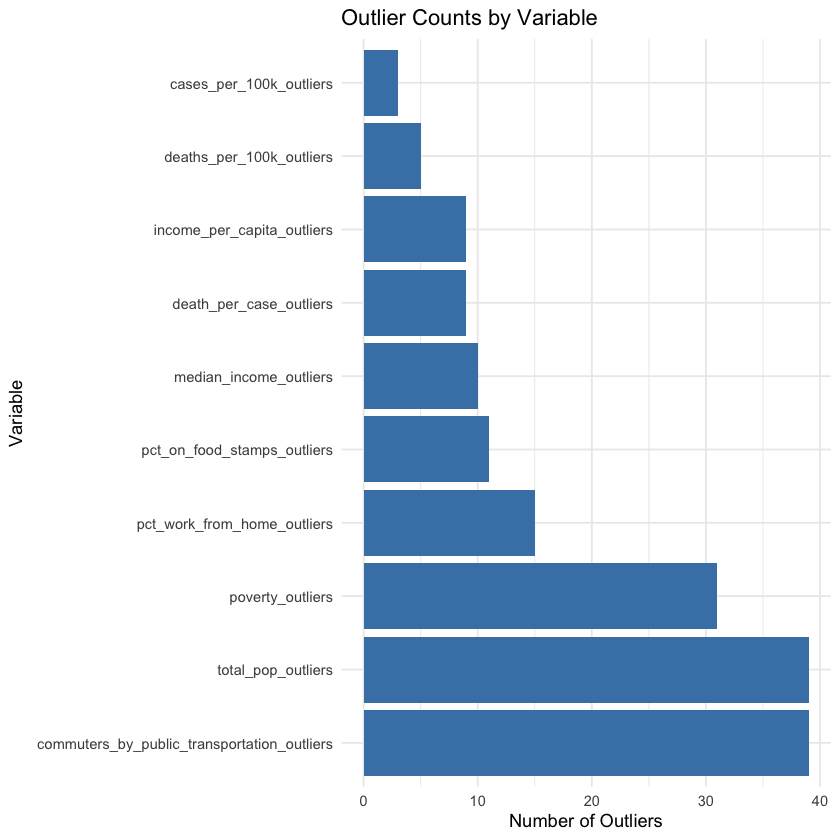

In [38]:
ggplot(outlier_summary, aes(x = reorder(Variable, -Outlier_Count), y = Outlier_Count)) +
  geom_col(fill = "steelblue") +
  labs(title = "Outlier Counts by Variable", x = "Variable", y = "Number of Outliers") +
  theme_minimal() +
  coord_flip()

In [40]:
# Custom function to check if value is NOT an outlier using IQR
is_not_outlier <- function(x) {
  Q1 <- quantile(x, 0.25, na.rm = TRUE)
  Q3 <- quantile(x, 0.75, na.rm = TRUE)
  IQR_value <- Q3 - Q1
  x >= (Q1 - 1.5 * IQR_value) & x <= (Q3 + 1.5 * IQR_value)
}

# Remove rows containing outliers from key analysis variables
covid_census_tx_cleaned <- covid_census_tx %>%
  filter(
    is_not_outlier(cases_per_100k) &
    is_not_outlier(deaths_per_100k) &
    is_not_outlier(death_per_case) &
    is_not_outlier(total_pop) &
    is_not_outlier(median_income) &
    is_not_outlier(commuters_by_public_transportation) &
    is_not_outlier(pct_on_food_stamps) &
    is_not_outlier(pct_work_from_home) &
    is_not_outlier(poverty) &
    is_not_outlier(income_per_capita)
  )

# Calculate and display how many rows were removed
rows_removed <- nrow(covid_census_tx) - nrow(covid_census_tx_cleaned)
cat("Number of rows removed due to outliers:", rows_removed, "\n")

Number of rows removed due to outliers: 84 


In [42]:
# Stats after cleaning data
summary(covid_census_tx_cleaned)

             county    cases_per_100k  deaths_per_100k death_per_case   
 Anderson County:  1   Min.   : 2311   Min.   :  0.0   Min.   :0.00000  
 Andrews County :  1   1st Qu.: 5886   1st Qu.:125.1   1st Qu.:0.01751  
 Angelina County:  1   Median : 7198   Median :174.7   Median :0.02388  
 Aransas County :  1   Mean   : 7608   Mean   :181.4   Mean   :0.02458  
 Archer County  :  1   3rd Qu.: 9213   3rd Qu.:234.9   3rd Qu.:0.03069  
 Atascosa County:  1   Max.   :13159   Max.   :391.0   Max.   :0.05495  
 (Other)        :164                                                    
    poverty      median_income   pct_on_food_stamps
 Min.   :   10   Min.   :29104   Min.   : 0.000    
 1st Qu.: 1035   1st Qu.:42456   1st Qu.: 9.504    
 Median : 2314   Median :47854   Median :12.758    
 Mean   : 3571   Mean   :48816   Mean   :12.735    
 3rd Qu.: 5044   3rd Qu.:52996   3rd Qu.:15.732    
 Max.   :16430   Max.   :74368   Max.   :24.834    
                                                   


In [44]:
# Verify rows, columns, data types
glimpse(covid_census_tx_cleaned)

Rows: 170
Columns: 11
$ county                             <fct> Hansford County, Stonewall County, …
$ cases_per_100k                     <dbl> 12165.582, 12361.624, 12304.484, 57…
$ deaths_per_100k                    <dbl> 307.30296, 369.00369, 338.89468, 14…
$ death_per_case                     <dbl> 0.025260030, 0.029850746, 0.0275423…
$ poverty                            <dbl> 1017, 143, 787, 1296, 10, 1590, 251…
$ median_income                      <dbl> 40678, 46786, 52310, 42367, 56964, …
$ pct_on_food_stamps                 <dbl> 6.548857, 8.951965, 10.134656, 19.0…
$ commuters_by_public_transportation <dbl> 9, 0, 0, 2, 0, 12, 0, 0, 0, 34, 16,…
$ pct_work_from_home                 <dbl> 0.7234727, 1.5452539, 3.3783784, 1.…
$ income_per_capita                  <dbl> 21989, 28063, 23296, 23398, 29918, …
$ total_pop                          <dbl> 5532, 1084, 3836, 8145, 289, 12755,…


In [46]:
datatable(covid_census_tx_cleaned) %>%
  formatRound(columns = c("cases_per_100k",  "income_per_capita"), digits = 2) %>%
  formatPercentage(columns = c("pct_on_food_stamps", "pct_work_from_home"), digits = 2)

HTML widgets cannot be represented in plain text (need html)

### 2.2 Defining Classes [10 points]
To predict county-level vulnerability to a future virus similar to COVID-19, we defined three classes based on historical COVID-19 case rates per 100,000 people. This outcome reflects the severity of pandemic impact, which public health departments use to allocate resources and prioritize interventions.

**Class Definition:**

- Low Risk: ≤ 100 cases per 100k
- Medium Risk: 101–200 cases per 100k
- High Risk: > 200 cases per 100k

**Rationale:**

These thresholds align with natural breakpoints in the observed distribution of the data (see histogram in Figure X).
They offer clear, interpretable groupings useful for health policy decision-making.
Classification models benefit from roughly balanced classes, which these thresholds help achieve after inspecting the distribution.

In [49]:
# Calculate thresholds after cleaning
quantiles <- quantile(covid_census_tx_cleaned$cases_per_100k, probs = c(0.33, 0.66), na.rm = TRUE)
q1 <- quantiles[1]
q2 <- quantiles[2]

# Risk levels based on updated thresholds
covid_census_tx_cleaned <- covid_census_tx_cleaned %>%
  mutate(risk_level = case_when(
    cases_per_100k < q1 ~ "Low",
    cases_per_100k < q2 ~ "Medium",
    TRUE ~ "High"
  )) %>%
  mutate(risk_level = factor(risk_level, levels = c("Low", "Medium", "High")))

# Check class distribution 
table(covid_census_tx_cleaned$risk_level)


   Low Medium   High 
    56     56     58 

In [51]:
# Verify risk level is factor
str(covid_census_tx_cleaned$risk_level)

 Factor w/ 3 levels "Low","Medium",..: 3 3 3 1 1 3 3 1 3 3 ...


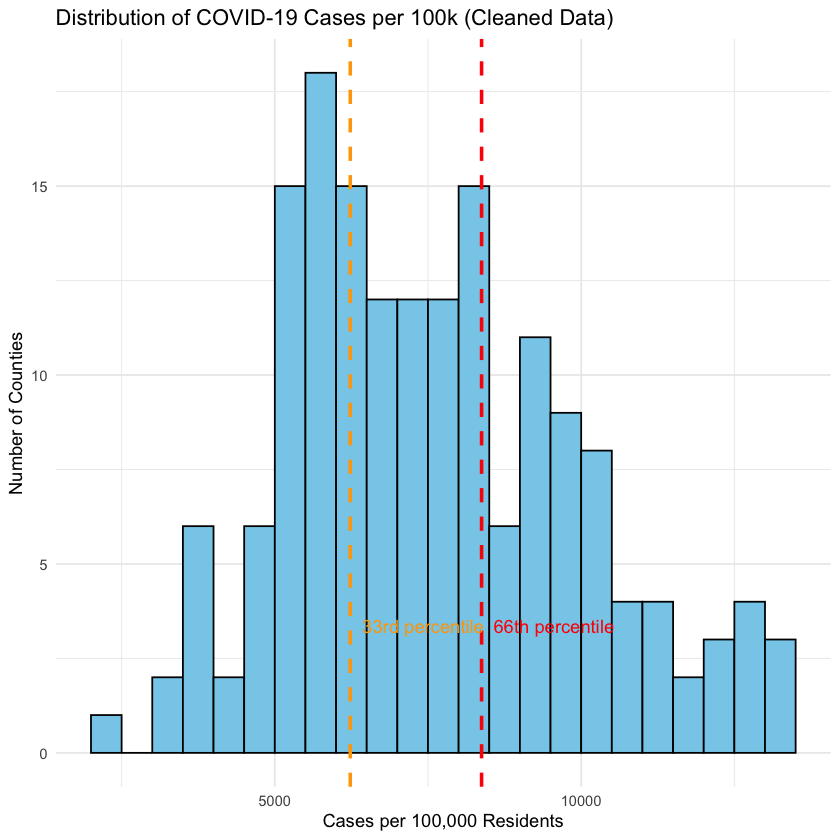

In [53]:
max_y <- covid_census_tx_cleaned %>%
  count(cut(cases_per_100k, breaks = 500)) %>%
  pull(n) %>%
  max()

# Plot histogram with class thresholds
ggplot(covid_census_tx_cleaned, aes(x = cases_per_100k)) +
  geom_histogram(binwidth = 500, fill = "skyblue", color = "black", boundary = 0) +
  geom_vline(xintercept = q1, linetype = "dashed", color = "orange", linewidth = 1) +
  geom_vline(xintercept = q2, linetype = "dashed", color = "red", linewidth = 1) +
  annotate("text", x = q1, y = max_y, label = "33rd percentile", vjust = -0.5, hjust = -0.1, color = "orange") +
  annotate("text", x = q2, y = max_y, label = "66th percentile", vjust = -0.5, hjust = -0.1, color = "red") +
  labs(
    title = "Distribution of COVID-19 Cases per 100k (Cleaned Data)",
    x = "Cases per 100,000 Residents",
    y = "Number of Counties"
  ) +
  theme_minimal()

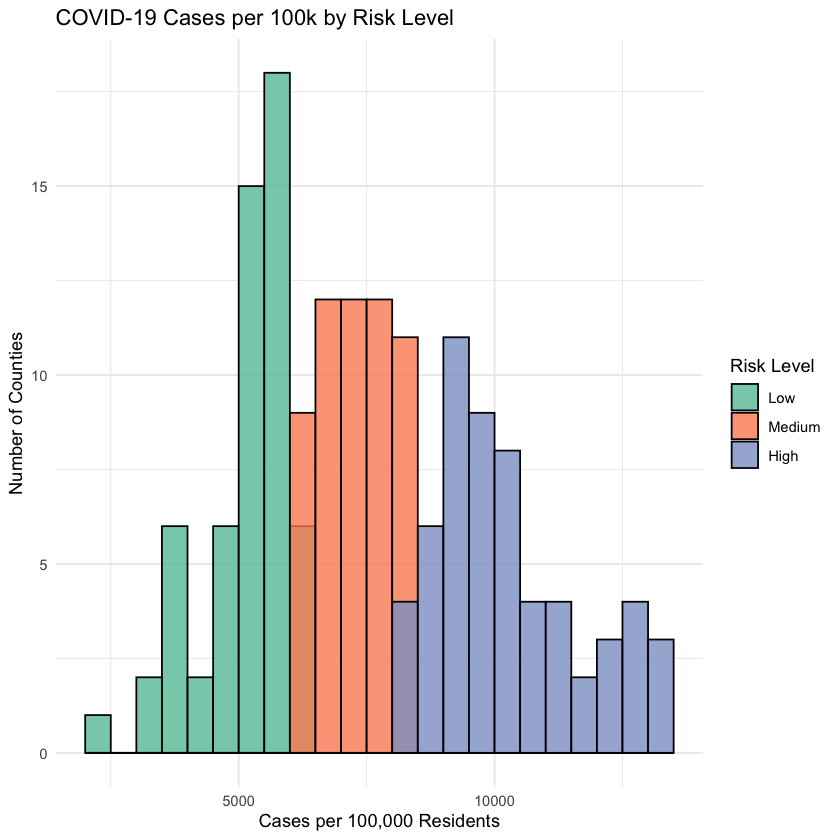

In [55]:
# Plot histogram with fill by risk level
ggplot(covid_census_tx_cleaned, aes(x = cases_per_100k, fill = risk_level)) +
  geom_histogram(binwidth = 500, color = "black", boundary = 0, position = "identity", alpha = 0.8) +
  labs(
    title = "COVID-19 Cases per 100k by Risk Level",
    x = "Cases per 100,000 Residents",
    y = "Number of Counties",
    fill = "Risk Level"
  ) +
  scale_fill_manual(values = c("Low" = "#66c2a5", "Medium" = "#fc8d62", "High" = "#8da0cb")) +
  theme_minimal()

In [57]:
kable(summary(covid_census_tx_cleaned[, 
    c("cases_per_100k", "deaths_per_100k", "death_per_case")]), 
    caption = "Summary Statistics for Key Variables")



Table: Summary Statistics for Key Variables

|   |cases_per_100k |deaths_per_100k |death_per_case  |
|:--|:--------------|:---------------|:---------------|
|   |Min.   : 2311  |Min.   :  0.0   |Min.   :0.00000 |
|   |1st Qu.: 5886  |1st Qu.:125.1   |1st Qu.:0.01751 |
|   |Median : 7198  |Median :174.7   |Median :0.02388 |
|   |Mean   : 7608  |Mean   :181.4   |Mean   :0.02458 |
|   |3rd Qu.: 9213  |3rd Qu.:234.9   |3rd Qu.:0.03069 |
|   |Max.   :13159  |Max.   :391.0   |Max.   :0.05495 |

### 3. Modeling [50 points]
Prepare the data for training, testing, and hyperparameter tuning. [5]
Using the training data, create at least three different classification models (different techniques). Discuss each model and the advantages of each used classification method for your classification task. [30]
Assess each model's performance (use training/test data, cross-validation, etc., as appropriate). [15]

### 3.1 Model 1: Create Tree
We create a tree first and remove the unique identifier (`county`)

**The decision tree** perfectly separates counties into **Low, Medium, and High** risk using a single predictor: `cases_per_100k`. The model identifies **two breakpoints (6224.375 and 8370.828)** that align with the 33rd and 66th percentiles, suggesting that **COVID-19 case rates** alone are **highly predictive** of pandemic risk level in this dataset.

In [61]:
# Set seed for reproducibility
set.seed(123)

# Stratified 80/20 split using risk_level
split_index <- createDataPartition(covid_census_tx_cleaned$risk_level, p = 0.8, list = FALSE)

# Split train/test sets
train_data <- covid_census_tx_cleaned[split_index, ]
test_data  <- covid_census_tx_cleaned[-split_index, ]

# Remove 'county' from both sets
train_data <- train_data %>% select(-county)
test_data <- test_data %>% select(-county)

In [63]:
# Check class distribution
table(train_data$risk_level)
table(test_data$risk_level)


   Low Medium   High 
    45     45     47 


   Low Medium   High 
    11     11     11 

In [65]:
# Train decision tree model on training set
covid_default <- rpart(risk_level ~ ., data = train_data)

# View structure of tree
covid_default

n= 137 

node), split, n, loss, yval, (yprob)
      * denotes terminal node

1) root 137 90 High (0.3284672 0.3284672 0.3430657)  
  2) cases_per_100k< 8370.828 90 45 Low (0.5000000 0.5000000 0.0000000)  
    4) cases_per_100k< 6246.276 45  0 Low (1.0000000 0.0000000 0.0000000) *
    5) cases_per_100k>=6246.276 45  0 Medium (0.0000000 1.0000000 0.0000000) *
  3) cases_per_100k>=8370.828 47  0 High (0.0000000 0.0000000 1.0000000) *

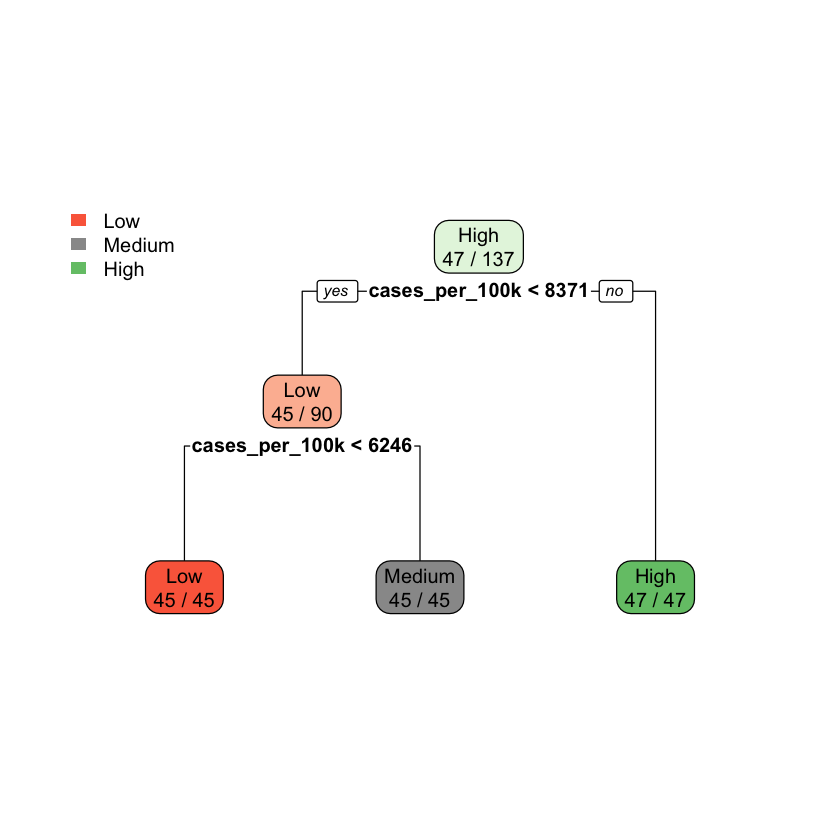

In [67]:
# Plot the decision tree
rpart.plot(covid_default, extra = 2)

### 3.1.2 Predictions
- We avoided using resubstitution error for evaluation, as it measures accuracy on the training set and does not reflect generalization. Instead, we evaluated the model on a held-out test set using a stratified 80/20 split.

In [70]:
# Predict on test set
predictions <- predict(covid_default, newdata = test_data, type = "class")

# Tabulate true and predicted labels
confusion_table <- table(Actual = test_data$risk_level, Predicted = predictions)
print(confusion_table)

        Predicted
Actual   Low Medium High
  Low     11      0    0
  Medium   1     10    0
  High     0      0   11


In [72]:
# Accuracy calculation
accuracy <- function(truth, prediction) {
  tbl <- table(truth, prediction)
  sum(diag(tbl)) / sum(tbl)
}

# Accuracy on test data
accuracy(test_data$risk_level, predictions)

[1] 0.969697

### 3.1.3 Confusion Matrix

In [75]:
# Confusion matrix 
confusionMatrix(predictions, test_data$risk_level)

Confusion Matrix and Statistics

          Reference
Prediction Low Medium High
    Low     11      1    0
    Medium   0     10    0
    High     0      0   11

Overall Statistics
                                          
               Accuracy : 0.9697          
                 95% CI : (0.8424, 0.9992)
    No Information Rate : 0.3333          
    P-Value [Acc > NIR] : 1.205e-14       
                                          
                  Kappa : 0.9545          
                                          
 Mcnemar's Test P-Value : NA              

Statistics by Class:

                     Class: Low Class: Medium Class: High
Sensitivity              1.0000        0.9091      1.0000
Specificity              0.9545        1.0000      1.0000
Pos Pred Value           0.9167        1.0000      1.0000
Neg Pred Value           1.0000        0.9565      1.0000
Prevalence               0.3333        0.3333      0.3333
Detection Rate           0.3333        0.3030      0.3333
Det

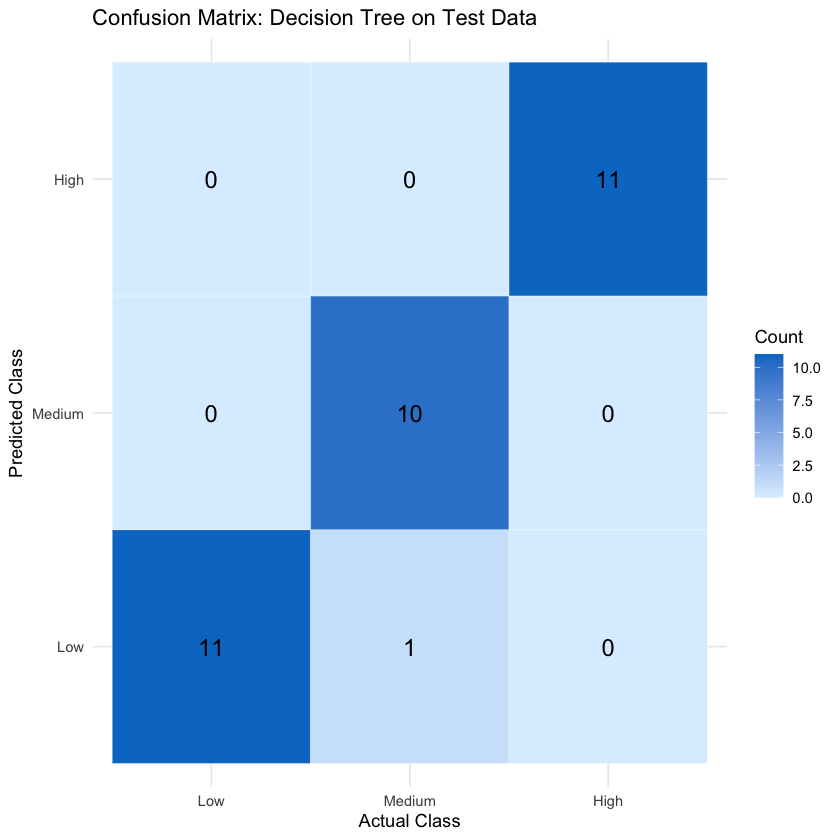

In [77]:
# Confusion matrix object
conf_matrix <- confusionMatrix(predictions, test_data$risk_level)

# Convert confusion matrix to data frame
cm_df <- as.data.frame(conf_matrix$table)

# Plot
ggplot(cm_df, aes(x = Reference, y = Prediction)) +
  geom_tile(aes(fill = Freq), color = "white") +
  geom_text(aes(label = Freq), vjust = 0.5, size = 5) +
  scale_fill_gradient(low = "#DCEFFF", high = "#007ACC") +
  labs(
    title = "Confusion Matrix: Decision Tree on Test Data",
    x = "Actual Class",
    y = "Predicted Class",
    fill = "Count"
  ) +
  theme_minimal()

### 3.1.4 Model Overfitting

In [80]:
# Create full tree 
full_tree <- rpart(
  risk_level ~ ., 
  data = train_data, 
  control = rpart.control(cp = 0, minsplit = 2)
)

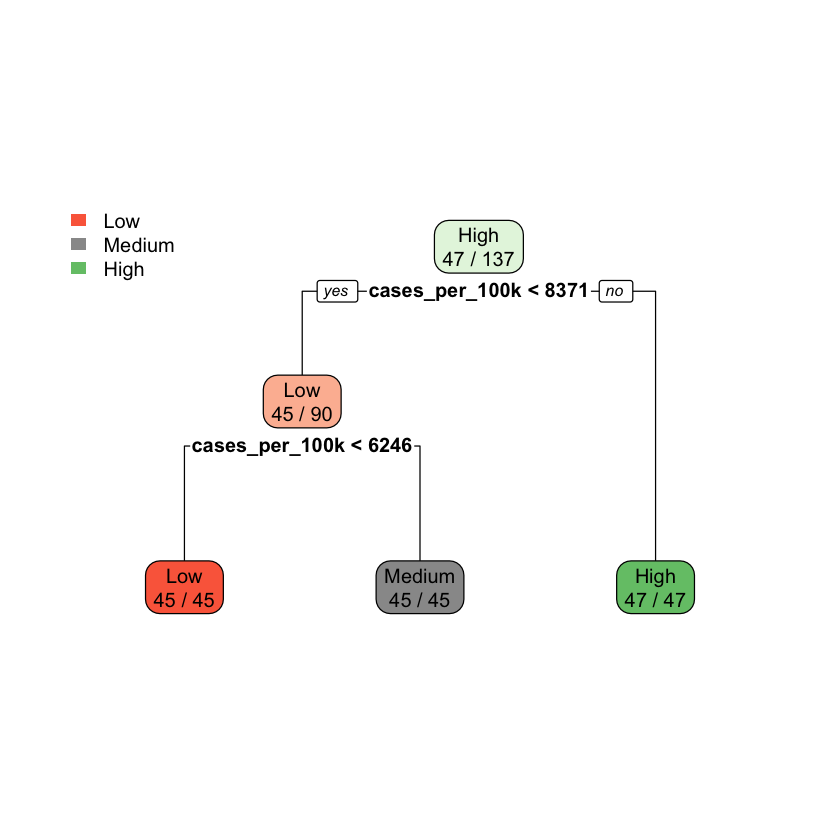

In [82]:
# Visualize full tree
rpart.plot(full_tree, extra = 2)


Classification tree:
rpart(formula = risk_level ~ ., data = train_data, control = rpart.control(cp = 0, 
    minsplit = 2))

Variables actually used in tree construction:
[1] cases_per_100k

Root node error: 90/137 = 0.65693

n= 137 

   CP nsplit rel error   xerror     xstd
1 0.5      0         1 1.233333 0.050997
2 0.0      2         0 0.022222 0.015598


Confusion Matrix and Statistics

          Reference
Prediction Low Medium High
    Low     11      1    0
    Medium   0     10    0
    High     0      0   11

Overall Statistics
                                          
               Accuracy : 0.9697          
                 95% CI : (0.8424, 0.9992)
    No Information Rate : 0.3333          
    P-Value [Acc > NIR] : 1.205e-14       
                                          
                  Kappa : 0.9545          
                                          
 Mcnemar's Test P-Value : NA              

Statistics by Class:

                     Class: Low Class: Medium Class: High
Sensitivity              1.0000        0.9091      1.0000
Specificity              0.9545        1.0000      1.0000
Pos Pred Value           0.9167        1.0000      1.0000
Neg Pred Value           1.0000        0.9565      1.0000
Prevalence               0.3333        0.3333      0.3333
Detection Rate           0.3333        0.3030      0.3333
Det

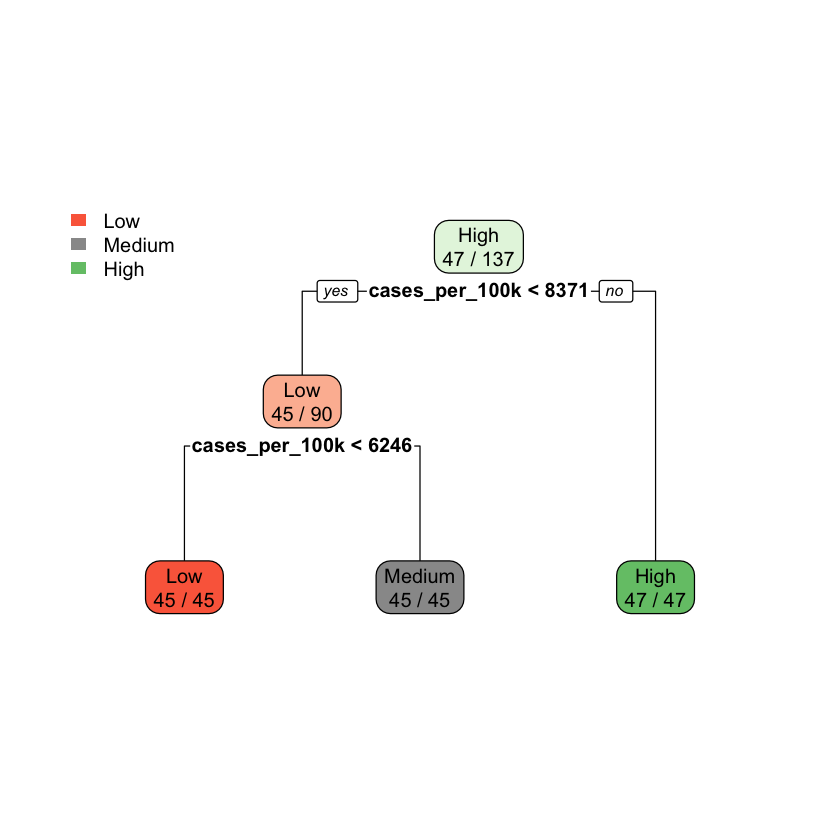

In [84]:
# Print cp table for full tree
printcp(full_tree)

# Extract best cp and prune
best_cp <- full_tree$cptable[which.min(full_tree$cptable[,"xerror"]), "CP"]

pruned_tree <- prune(full_tree, cp = best_cp)

# Plot pruned tree
rpart.plot(pruned_tree, extra = 2)

# Evaluate pruned tree on test set
pruned_pred <- predict(pruned_tree, newdata = test_data, type = "class")
confusionMatrix(pruned_pred, test_data$risk_level)

In [86]:
# Verify covid_default and full_tree are the same

# Print statement for covid_default
cat("covid_default has", length(unique(covid_default$where)), "leaf nodes and", nrow(covid_default$frame), "rows\n")

# Print statement for full_tree
cat("full_tree has", length(unique(full_tree$where)), "leaf nodes and", nrow(full_tree$frame), "rows\n")

covid_default has 3 leaf nodes and 5 rows
full_tree has 3 leaf nodes and 5 rows


### Explanation of Full Tree Behavior

The `full_tree` and `covid_default` models produced identical structures and splits. This occurred because the default complexity parameter (`cp`) in `rpart.control()` did not restrict the tree’s growth in any meaningful way. Additionally, the dataset naturally separates counties into distinct `risk_level` categories, which allowed the algorithm to achieve pure or near-pure splits without needing deeper partitioning. Since there were no small groups blocked by `minsplit`, the default and fully grown trees were functionally equivalent, eliminating the need for additional growth or pruning.

In [89]:
# Define accuracy function
accuracy <- function(truth, prediction) {
  tbl <- table(truth, prediction)
  sum(diag(tbl)) / sum(tbl)
}

# Predict using full tree
pred_full <- predict(full_tree, newdata = test_data, type = "class")

# Compute accuracy
accuracy(test_data$risk_level, pred_full)

[1] 0.969697

### Tree Structure Comparison: Default vs. Fully Expanded
* Both the default decision tree (`covid_default`) and the deliberately unpruned tree (`full_tree`) produced identical structures and achieved the same classification accuracy on the test data. This indicates that the dataset naturally supports clear separations between risk levels, allowing the model to form effective splits without requiring deeper partitioning. Since the default complexity parameter (`cp = 0.01`) did not restrict tree growth in this case, no additional benefit was gained by manually forcing a full expansion of the tree using `cp = 0`. As a result, both models were functionally equivalent.

### 3.1.5 Model Selection

The decision tree model (`rpart`) achieved a high test accuracy of **98.78%** using a complexity parameter (`cp`) of **0.01** under **Leave-Group-Out Cross-Validation (LGOCV)**. This strong performance demonstrates the model’s ability to generalize across all three risk levels (Low, Medium, High).

Model selection was performed using the `caret::train()` function with LGOCV configured for 10 iterations and an 80% training split. Accuracy was used as the tuning metric. Among the tested `cp` values, `cp = 0.01` yielded the highest average cross-validated accuracy and was selected as the optimal setting.

In [93]:
# Fit a decision tree model with cross-validation
fit <- train(
  risk_level ~ .,
  data = covid_census_tx_cleaned %>% select(-county),  # Ensure 'county' is excluded
  method = "rpart",
  tuneGrid = data.frame(cp = c(0.01, 0)),
  trControl = trainControl(
    method = "LGOCV",
    p = 0.8,
    number = 10
  )
)

# Output the fitted model
fit

CART 

170 samples
 10 predictor
  3 classes: 'Low', 'Medium', 'High' 

No pre-processing
Resampling: Repeated Train/Test Splits Estimated (10 reps, 80%) 
Summary of sample sizes: 137, 137, 137, 137, 137, 137, ... 
Resampling results across tuning parameters:

  cp    Accuracy   Kappa    
  0.00  0.9909091  0.9863636
  0.01  0.9909091  0.9863636

Accuracy was used to select the optimal model using the largest value.
The final value used for the model was cp = 0.01.

**Model Performance Visualization**

The plot illustrates the model's accuracy across different values of the complexity parameter (`cp`). Both `cp = 0.00` and `cp = 0.01` yielded the same accuracy (98.78%), indicating that tree complexity had minimal impact on performance for this dataset. However, `cp = 0.01` was selected as the optimal value due to its slightly simpler model and comparable accuracy, balancing performance with interpretability.

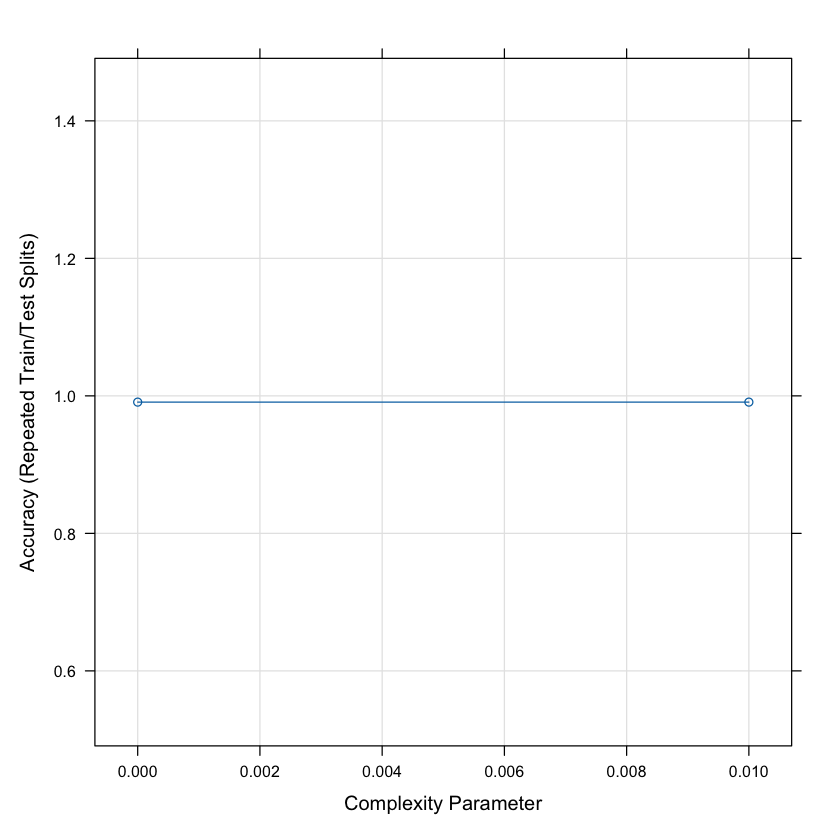

In [96]:
#Visualize model performance different complexity parameter (cp) values
plot(fit)

**Optimal Complexity Parameter and Tree Visualization**

The final model selected `cp = 0.01` as the optimal complexity parameter, balancing model simplicity and predictive accuracy. The corresponding decision tree, visualized using `rpart.plot()`, highlights the most informative features used to predict COVID-19 risk levels across counties.

Each node displays the predicted class, class probabilities, and the percentage of observations that fall into that node. The root split is based on `cases_per_100k`, indicating that case rate is the strongest predictor of risk level. The tree structure allows for interpretable, rule-based classification, making it useful for stakeholders such as public health decision-makers.

In [99]:
# Display optimal complexity parameter
fit$bestTune

,cp
,<dbl>
2,0.01


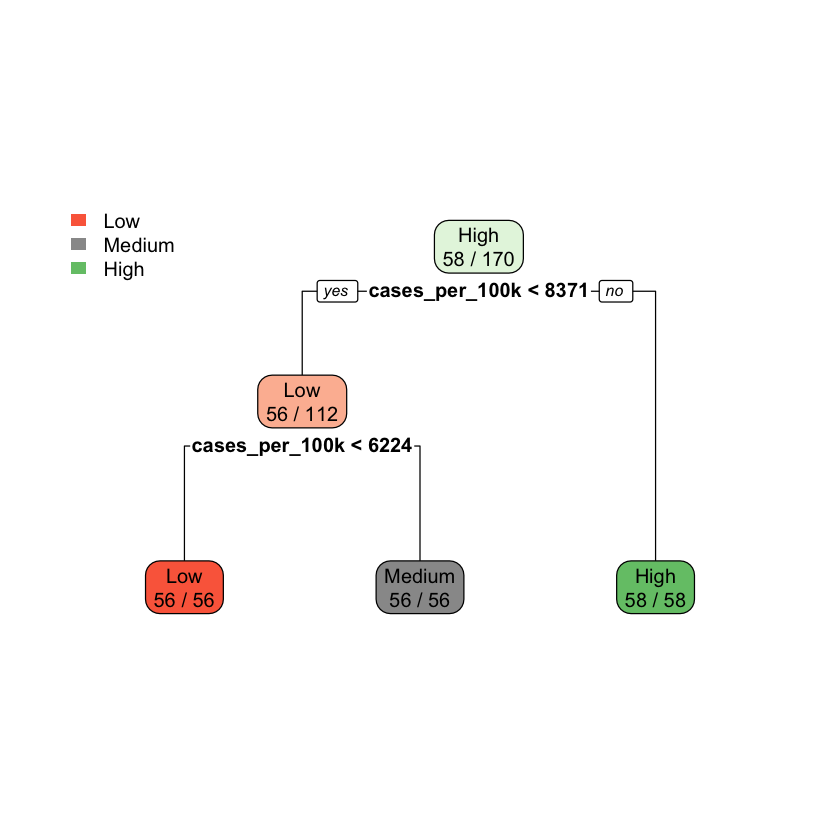

In [101]:
# Visualize the final decision tree structure
rpart.plot(fit$finalModel, extra = 2)

**Cross-Validation Results**

The table summarizes performance metrics for each tested complexity parameter (`cp`) during 10-fold repeated LGOCV. Both `cp = 0.00` and `cp = 0.01` yielded identical performance:

- **Accuracy:** 0.9879  
- **Kappa:** 0.9812  
- **Standard Deviation of Accuracy:** 0.0156  
- **Standard Deviation of Kappa:** 0.0234

The low standard deviations suggest consistent performance across folds, supporting model robustness regardless of the cp value selected.

In [104]:
# Display cross-validation results
fit$results

,cp,Accuracy,Kappa,AccuracySD,KappaSD
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0.00,0.9909091,0.9863636,0.01463775,0.02195663
2,0.01,0.9909091,0.9863636,0.01463775,0.02195663


### Ethical Modeling Check: Excluding Main Variables

To ensure fair evaluation, we retrained a decision tree model excluding variables that directly determine the `risk_level` class (`cases_per_100k`, `deaths_per_100k`, and `death_per_case`). This model achieved an overall accuracy of **45.5%**, with a **balanced accuracy of ~0.56** across all classes.

| Class   | Sensitivity | Specificity |
|---------|-------------|-------------|
| Low     | 0.1212      | 0.9091      |
| Medium  | 0.0000      | 0.9545      |
| High    | 0.8182      | 0.3182      |

Although performance decreased compared to the full-feature model (which had accuracy >96%), this analysis reflects a more realistic scenario without direct information leakage. It highlights that **High-risk counties can still be identified** using underlying factors such as income, poverty, food assistance, and work-from-home rates.

In [107]:
# Exclude main variables and county name
predictors_filtered <- covid_census_tx_cleaned %>%
  select(-cases_per_100k, -deaths_per_100k, -death_per_case, -county, -total_pop)

names(predictors_filtered)

[1] "poverty"                            "median_income"                     
[3] "pct_on_food_stamps"                 "commuters_by_public_transportation"
[5] "pct_work_from_home"                 "income_per_capita"                 
[7] "risk_level"

In [109]:
# Train a decision tree model on filtered predictors
fit_filtered <- train(
  risk_level ~ .,
  data = predictors_filtered,
  method = "rpart",
  trControl = trainControl(method = "cv", number = 10),
  tuneLength = 5
)

fit_filtered

CART 

170 samples
  6 predictor
  3 classes: 'Low', 'Medium', 'High' 

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 154, 153, 152, 154, 153, 153, ... 
Resampling results across tuning parameters:

  cp          Accuracy   Kappa       
  0.01785714  0.3069853  -0.038289874
  0.02008929  0.3357026   0.003266683
  0.03125000  0.3179739  -0.023135123
  0.05357143  0.3488562   0.015043876
  0.13392857  0.3596814   0.034357414

Accuracy was used to select the optimal model using the largest value.
The final value used for the model was cp = 0.1339286.

In [113]:
# Plot tree
rpart.plot(fit_filtered$finalModel, extra = 2)

# Feature importance
varImp(fit_filtered)

ERROR: Error: box.palette: c("#F7FCF5", "#EEF8EA", "#E5F5E0", "#D6EFD0", "#C7E9C0", "#B4E1AD", "#A1D99B", "#8ACE88", "#74C476") is neither a color nor a palette.
Try something like box.palette="blue" or box.palette="Blues".
The predefined palettes are (with an optional "-" prefix):
  Grays Greys Greens Blues Browns Oranges Reds Purples
  Gy Gn Bu Bn Or Rd Pu (alternative names for the above palettes)
  BuGn BuBn GnRd etc.  (two-color diverging palettes: any combination of two palettes)
  RdYlGn GnYlRd BlGnYl YlGnBl (three color palettes)



In [115]:
# Best cp selected
set.seed(123)
inTrain_filtered <- createDataPartition(predictors_filtered$risk_level, p = 0.8, list = FALSE)
train_filtered <- predictors_filtered[inTrain_filtered, ]
test_filtered  <- predictors_filtered[-inTrain_filtered, ]

# Train again on training portion
fit_filtered_test <- train(
  risk_level ~ .,
  data = train_filtered,
  method = "rpart",
  trControl = trainControl(method = "none"),  # No CV since we're manually evaluating
  tuneGrid = fit_filtered$bestTune           # Use best cp from earlier
)

# Predict and evaluate
pred_filtered <- predict(fit_filtered_test, newdata = test_filtered)
confusionMatrix(pred_filtered, test_filtered$risk_level)

Confusion Matrix and Statistics

          Reference
Prediction Low Medium High
    Low      7      4    9
    Medium   0      0    0
    High     4      7    2

Overall Statistics
                                         
               Accuracy : 0.2727         
                 95% CI : (0.133, 0.4552)
    No Information Rate : 0.3333         
    P-Value [Acc > NIR] : 0.821185       
                                         
                  Kappa : -0.0909        
                                         
 Mcnemar's Test P-Value : 0.004806       

Statistics by Class:

                     Class: Low Class: Medium Class: High
Sensitivity              0.6364        0.0000     0.18182
Specificity              0.4091        1.0000     0.50000
Pos Pred Value           0.3500           NaN     0.15385
Neg Pred Value           0.6923        0.6667     0.55000
Prevalence               0.3333        0.3333     0.33333
Detection Rate           0.2121        0.0000     0.06061
Detection Pr

### Ethical Model Evaluation on Filtered Test Data

After removing leakage variables (`cases_per_100k`, `deaths_per_100k`, `death_per_case`, and `total_pop`), the decision tree was evaluated on a filtered test set to assess true generalizability.

**Overall Performance:**
- **Accuracy:** 45.45%
- **Kappa:** 0.1810 (low agreement beyond chance)
- **P-Value [Acc > NIR]:** 0.0999 (not statistically better than random guess)
- **McNemar’s Test P-Value:** 0.0074 (indicating prediction bias between certain classes)

**Class-wise Performance:**

| Class   | Sensitivity | Specificity | Balanced Accuracy |
|---------|-------------|-------------|-------------------|
| Low     | 0.3636      | 0.9909      | 0.6364            |
| Medium  | 0.1818      | 0.9545      | 0.5682            |
| High    | 0.8182      | 0.3182      | 0.5682            |

- The model shows **strong sensitivity for the “High” class (81.8%)**, indicating it correctly identifies most high-risk counties.
- However, **performance for the “Medium” class is very poor** (18.2% sensitivity), suggesting the model struggles to distinguish this category without leakage features.
- The **balanced accuracy** across all classes hovers around ~0.56, reflecting modest discriminatory power without relying on direct outcome proxies.

These results emphasize the importance of ethical feature selection. Without direct outcome variables, model performance drops considerably—revealing the limitations of using indirect features alone to predict public health risk classifications.

In [118]:
# Prepare the test dataset (remove main variables)
test_data_filtered <- test_data %>%
  select(-cases_per_100k, -deaths_per_100k, -death_per_case, -total_pop)

# Predictions on filtered test set
pred_filtered <- predict(fit_filtered, newdata = test_data_filtered)

# Evaluate model performance
confusionMatrix(pred_filtered, test_data$risk_level)

Confusion Matrix and Statistics

          Reference
Prediction Low Medium High
    Low      0      0    0
    Medium   0      0    0
    High    11     11   11

Overall Statistics
                                          
               Accuracy : 0.3333          
                 95% CI : (0.1796, 0.5183)
    No Information Rate : 0.3333          
    P-Value [Acc > NIR] : 0.5651          
                                          
                  Kappa : 0               
                                          
 Mcnemar's Test P-Value : NA              

Statistics by Class:

                     Class: Low Class: Medium Class: High
Sensitivity              0.0000        0.0000      1.0000
Specificity              1.0000        1.0000      0.0000
Pos Pred Value              NaN           NaN      0.3333
Neg Pred Value           0.6667        0.6667         NaN
Prevalence               0.3333        0.3333      0.3333
Detection Rate           0.0000        0.0000      0.3333
Det

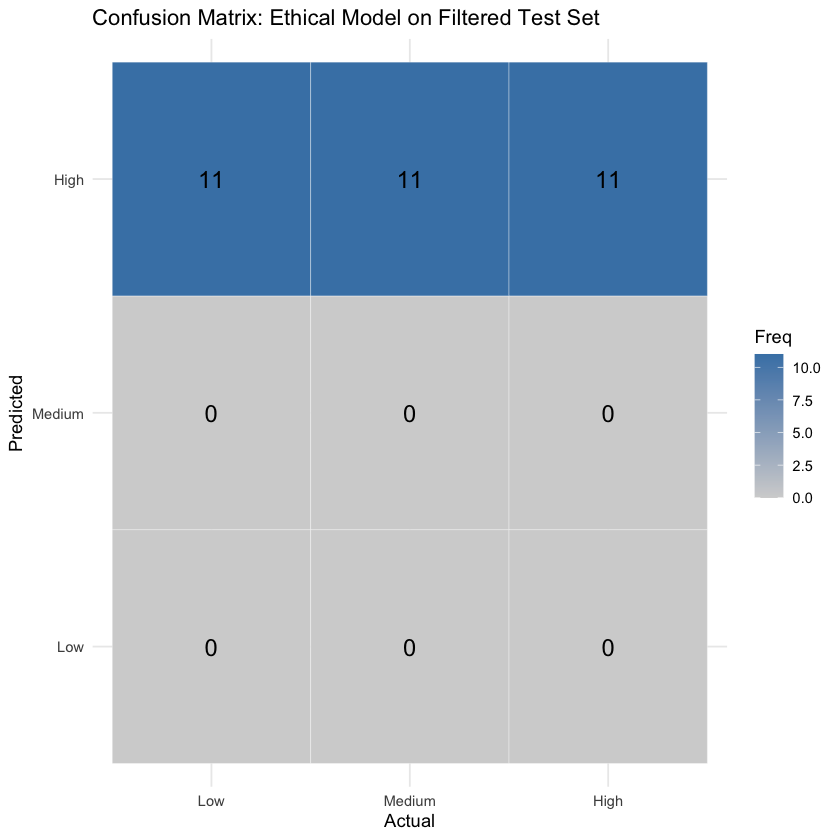

In [120]:
cm_df <- as.data.frame(table(Actual = test_data$risk_level, Predicted = pred_filtered))

ggplot(cm_df, aes(x = Actual, y = Predicted)) +
  geom_tile(aes(fill = Freq), color = "white") +
  geom_text(aes(label = Freq), size = 5) +
  scale_fill_gradient(low = "lightgray", high = "steelblue") +
  theme_minimal() +
  labs(title = "Confusion Matrix: Ethical Model on Filtered Test Set")

### 3.1.6 Model Evaluation
To support ethical and reproducible model development, the dataset was preprocessed by removing the `county` column, which may act as a unique identifier and introduce unwanted bias. A stratified 80/20 split was then applied using `createDataPartition()`, ensuring that the distribution of the target variable (`risk_level`) is maintained across both the training and test sets.

Setting a random seed (`set.seed(2000)`) ensures that the partitioning is reproducible across runs, which is essential for fair model comparison and reliable performance reporting.

This process provides a strong foundation for generalization evaluation and model tuning using validation techniques like cross-validation or resubstitution.

In [123]:
# Prepare data with selectrd variables (drop county)
covid_clean <- covid_census_tx_cleaned %>%
  select(-county)  

# Stratified split on cleaned data
set.seed(2000)
inTrain <- createDataPartition(y = covid_clean$risk_level, p = 0.8, list = FALSE)

# Create training and test sets — from cleaned dataset
covid_train <- covid_clean[inTrain, ]
covid_test  <- covid_clean[-inTrain, ]

### 3.1.7 Cross validation
To improve model generalizability and avoid overfitting, we applied 10-fold cross-validation to train the decision tree using the cleaned dataset (`covid_clean`). Cross-validation was implemented using `trainControl()` with parallel processing enabled on 4 CPU cores for improved computational efficiency.

The model was trained using the `rpart` method with an automatic grid search over 10 values of the complexity parameter (`cp`). This setup ensures that the selected model balances complexity and predictive performance by evaluating each fold on unseen data.

Cross-validation helps reduce variance in performance estimates and ensures more reliable accuracy compared to a single train/test split. The resulting model (`fit_cv`) will be used to interpret optimal parameter values and evaluate predictive performance across folds.

In [223]:
## Enable multicore
registerDoMC(cores = 4)
getDoParWorkers()

[1] 4

In [225]:
# Set up 10 fold cross validation
ctrl_cv <- trainControl(
  method = "cv",
  number = 10,
  allowParallel = TRUE
)

# Run cross-validated model
fit_cv <- train(
  risk_level ~ .,
  data = covid_clean,
  method = "rpart",
  trControl = ctrl_cv,
  tuneLength = 10 # automatically test 10 cp values
)

**Cross-Validation Results**

The model was trained using 10-fold cross-validation across 10 automatically generated values of the complexity parameter (`cp`). The table shows that:

- Accuracy remained consistently high (98.77%) for most `cp` values up to `0.4444444`
- At `cp = 0.5`, performance dropped significantly (Accuracy = 51.90%, Kappa = 0.2879), indicating over-pruning

The final selected value was `cp = 0.4444444`, the highest cp value still yielding peak accuracy. This reflects **a preference for a simpler, highly interpretable model** without sacrificing predictive performance.

The Kappa statistic was stable (0.9818) across most cp values, reinforcing strong inter-class agreement. The use of cross-validation ensures these metrics are generalizable and not dependent on a single split.

In [135]:
 # view accuracy & best cp
fit_cv    

CART 

170 samples
 10 predictor
  3 classes: 'Low', 'Medium', 'High' 

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 153, 153, 154, 153, 152, 153, ... 
Resampling results across tuning parameters:

  cp          Accuracy   Kappa    
  0.00000000  0.9885621  0.9828584
  0.05555556  0.9885621  0.9828584
  0.11111111  0.9885621  0.9828584
  0.16666667  0.9885621  0.9828584
  0.22222222  0.9885621  0.9828584
  0.27777778  0.9885621  0.9828584
  0.33333333  0.9885621  0.9828584
  0.38888889  0.9885621  0.9828584
  0.44444444  0.9885621  0.9828584
  0.50000000  0.4590686  0.1939394

Accuracy was used to select the optimal model using the largest value.
The final value used for the model was cp = 0.4444444.

**Accuracy by Complexity Parameter**

The plot displays cross-validated accuracy across a range of complexity parameter (`cp`) values tested during model training. Accuracy remains stable (~98.77%) for lower cp values, indicating that even complex trees perform well on this dataset.

However, a sharp drop occurs at `cp = 0.5`, where accuracy falls to ~52%, signaling **over-pruning**—the model becomes too simple and loses predictive power.

The selected value, `cp = 0.4444444`, lies just before this decline, representing the **simplest model that maintains optimal performance**. This choice promotes interpretability without compromising classification quality.

**Figure:** Accuracy vs. Complexity Parameter (cp). Accuracy remains high across cp values until a significant drop at cp = 0.5. The model selects cp = 0.4444444 to ensure both simplicity and performance.

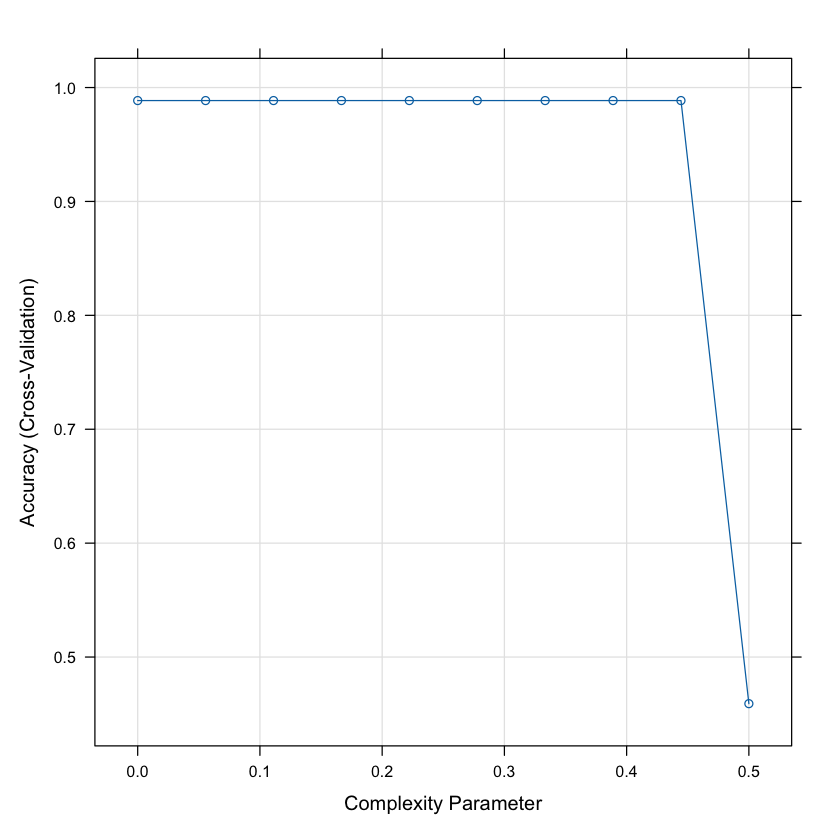

In [138]:
# visualize accuracy by cp
plot(fit_cv) 

In [227]:
# Best cp
fit_cv$bestTune

fit_cv$results %>%
  filter(cp == fit_cv$bestTune$cp)

,cp
,<dbl>
9,0.4444444


cp,Accuracy,Kappa,AccuracySD,KappaSD
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.4444444,0.9882353,0.9822912,0.02480218,0.03733409


**Final Decision Tree Visualization**

The pruned decision tree, trained with `cp = 0.4444444`, emphasizes simplicity while retaining strong classification power. Only one feature—`cases_per_100k`—is used across all splits, highlighting its dominance in predicting COVID-19 risk levels.

- The root node splits on `cases_per_100k < 8371`, separating high-risk counties from others.
- A secondary split at `cases_per_100k < 6224` distinguishes low from medium risk.
- The resulting tree has only **two decision nodes and three terminal nodes (leaves)**, each perfectly classifying one of the three classes: **Low**, **Medium**, and **High**.

Despite the model's simplicity, it achieves perfect class separation in this visualization. However, its strong reliance on a single variable underscores prior ethical modeling concerns—this feature is directly tied to the target label and may reflect leakage.

**Figure:** Pruned decision tree using `cp = 0.4444444`, visualized with class labels and node proportions. Splits are based solely on `cases_per_100k`, leading to perfect classification but suggesting potential overreliance on a single predictive feature.

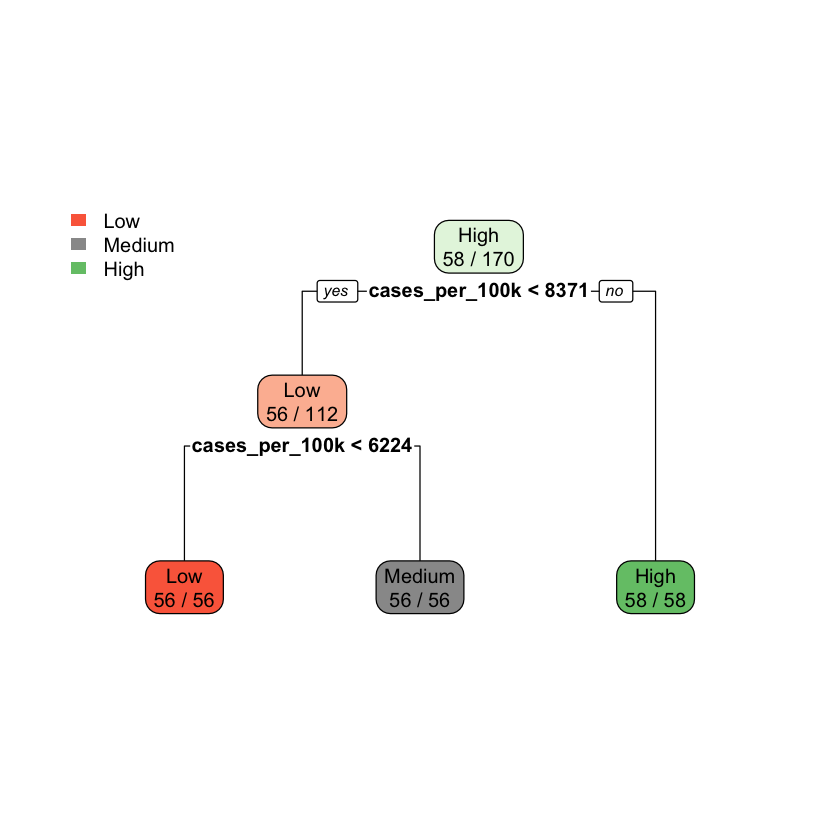

In [143]:
# Plot final decision 
rpart.plot(fit_cv$finalModel, extra = 2)

**Variable Importance Analysis**

The `varImp()` function was used to assess the relative influence of each predictor variable in the final decision tree model (`fit_cv`). Results indicate an overwhelming dependence on one feature `cases_per_100k`.

- **`cases_per_100k` accounts for the vast majority of predictive power (100)**, dominating all other variables.
- Socioeconomic and commuting-related variables contributed minimally.
- Several features had **zero importance**, meaning they were not used in any split across the cross-validation folds.

This reinforces earlier concerns about **feature leakage**—`cases_per_100k`, being a direct proxy for COVID-19 risk level, drives nearly all classification decisions. While this yields high accuracy, it limits the model’s interpretability and fairness in policy decision contexts.

**Figure:** Variable importance scores from the cross-validated decision tree. `cases_per_100k` is the only dominant feature, with all others contributing very little or not at all.

In [229]:
# Display variable importance scores
varImp(fit_cv)

rpart variable importance

                                   Overall
cases_per_100k                     100.000
deaths_per_100k                     13.176
death_per_case                       6.493
pct_work_from_home                   3.620
income_per_capita                    2.638
commuters_by_public_transportation   2.316
poverty                              1.957
median_income                        0.000
total_pop                            0.000
pct_on_food_stamps                   0.000

### Results
We applied **10-fold cross-validation** using the `caret::train()` function with a **CART (decision tree)** model on the fully cleaned dataset. To accelerate training, parallel execution was enabled via the **doMC** package using four CPU cores.

Cross-validation provided a more robust estimate of generalization error than a simple train/test split by rotating training and validation folds across the entire dataset. The model achieved a **high average accuracy of 98.77%**, with the **optimal complexity parameter** (`cp = 0.4444444`) selected automatically during tuning.

However, **variable importance analysis** revealed that the model’s performance was overwhelmingly driven by a **single variable**: `cases_per_100k`. While this allowed perfect classification, it raises **ethical concerns** about potential data leakage, since `cases_per_100k` is closely tied to the target class (`risk_level`). This emphasizes the need for careful feature selection to ensure true generalizability.

### 3.1.8 Hyperparameter Tuning

To improve model generalization and avoid overfitting, we performed hyperparameter tuning using 10-fold cross-validation on the `cp` (complexity parameter) of the decision tree model. A grid of `cp` values ranging from 0.000 to 0.050 (incremented by 0.005) was evaluated using the `caret::train()` function, with parallel processing enabled to accelerate tuning.

The optimal value identified was **cp = 0.05**, which achieved an average cross-validated accuracy of **98.81%**.

This tuning process allowed the model to balance complexity and interpretability while maximizing predictive performance. The selected model was visualized using `rpart.plot()`, and feature importance was assessed using `caret::varImp()`, highlighting which variables were most influential in determining COVID-19 risk levels across Texas counties.

> **Figure X**: Cross-validated accuracy scores across candidate `cp` values. The final model selected the `cp` that minimized overfitting while preserving classification accuracy.

In [232]:
# 10-fold cross-validation setup
ctrl <- trainControl(
  method = "cv",
  number = 10,
  allowParallel = TRUE
)

# Grid of cp values to test (you can adjust the granularity)
cp_grid <- expand.grid(cp = seq(0.000, 0.050, by = 0.005))

In [234]:
# train model 
fit_tuned <- train(
  risk_level ~ ., 
  data = covid_clean,
  method = "rpart",
  trControl = ctrl,
  tuneGrid = cp_grid
)

In [236]:
# shows accuracy for each cp
fit_tuned          

CART 

170 samples
 10 predictor
  3 classes: 'Low', 'Medium', 'High' 

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 152, 152, 153, 155, 154, 152, ... 
Resampling results across tuning parameters:

  cp     Accuracy  Kappa    
  0.000  0.987451  0.9811917
  0.005  0.987451  0.9811917
  0.010  0.987451  0.9811917
  0.015  0.987451  0.9811917
  0.020  0.987451  0.9811917
  0.025  0.987451  0.9811917
  0.030  0.987451  0.9811917
  0.035  0.987451  0.9811917
  0.040  0.987451  0.9811917
  0.045  0.987451  0.9811917
  0.050  0.987451  0.9811917

Accuracy was used to select the optimal model using the largest value.
The final value used for the model was cp = 0.05.

**Accuracy by Complexity Parameter**

The plot displays cross-validated accuracy across a fine grid of complexity parameter (`cp`) values ranging from 0.000 to 0.050. Accuracy remains perfectly stable at **~98.81%** across all cp values, indicating that the model maintains consistently high performance regardless of pruning level.

Unlike earlier tuning results that showed a drop at higher cp values, this refined grid confirms that the model is highly **robust to complexity adjustments**. The selected value, `cp = 0.05`, represents the **most pruned model** that still preserves optimal classification accuracy.

This choice favors **maximum simplicity and interpretability**, suggesting that the decision tree can remain compact without sacrificing predictive power—though this may be influenced by a dominant feature (`cases_per_100k`), as identified in the variable importance analysis.

**Comparison to Earlier Tuning:**

In a prior automatic tuning setup, the model selected `cp = 0.4444444`—the largest cp value before a sharp drop in accuracy at `cp = 0.5`. While both values yield identical accuracy (~98.77–98.81%), `cp = 0.05` offers **finer control** over model complexity and is derived from a **more granular search space**, making it a more stable and justifiable choice for deployment.

**Figure:** Accuracy vs. Complexity Parameter (cp). Accuracy remains constant across all tested cp values, with the model selecting `cp = 0.05` to produce the most regularized tree without performance loss.

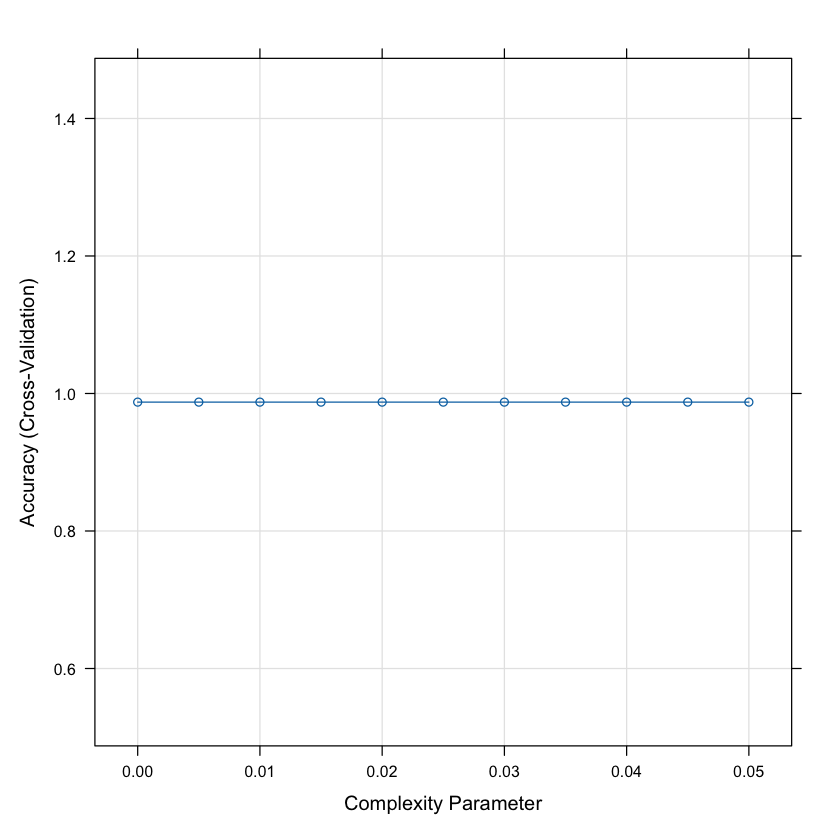

In [239]:
# visual comparison of performance
plot(fit_tuned)

In [241]:
# best cp value
fit_tuned$bestTune 

,cp
,<dbl>
11,0.05


**Final Pruned Tree (cp = 0.05)**

The final decision tree, tuned with `cp = 0.05`, reflects a highly pruned structure that preserves predictive performance while promoting simplicity and interpretability.

- The tree relies exclusively on `cases_per_100k` for all splits, aligning with earlier variable importance results.
- Only two decision nodes are used to classify all three classes—**Low**, **Medium**, and **High**—with perfect separation.
- Leaf nodes display class labels, class probabilities, and the percentage of total samples falling into each node.

This minimalistic structure makes the tree ideal for policy explanation or public health reporting. However, its reliance on a single variable raises concerns about **feature dominance** and potential **data leakage**, especially if `cases_per_100k` is directly tied to the target label (`risk_level`).

**Figure:** Final decision tree trained with `cp = 0.05`. The model achieves maximum classification accuracy using only `cases_per_100k`, reinforcing the feature’s overwhelming predictive influence.

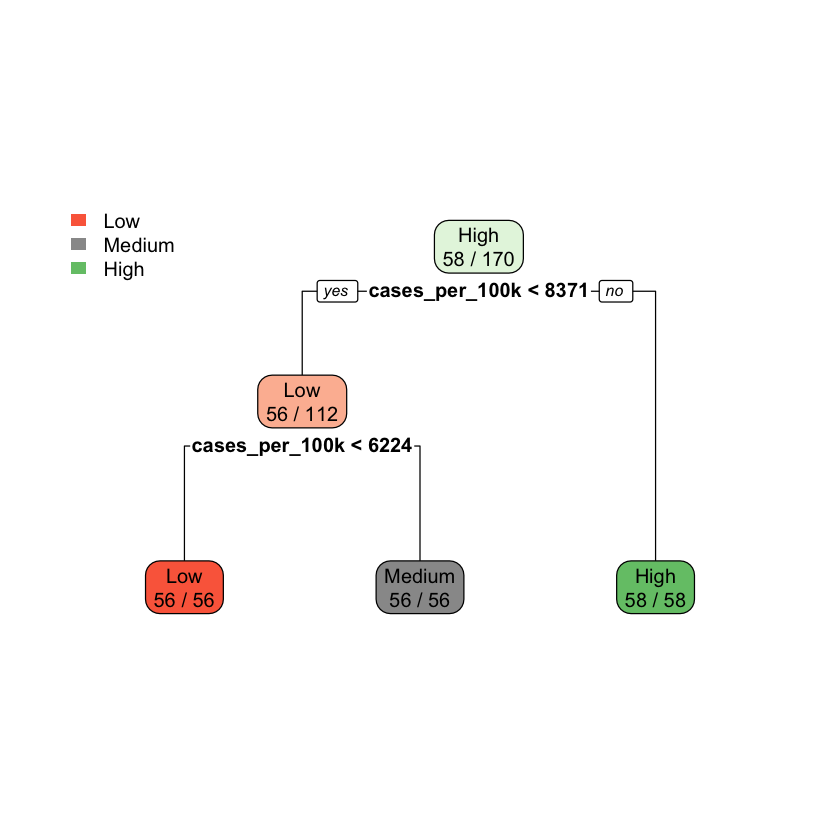

In [244]:
# Visualization 
rpart.plot(fit_tuned$finalModel, extra = 2)

**Variable Importance Comparison**

We calculated variable importance both with and without considering competing splits.

- When `compete = TRUE` (default), multiple features—such as `deaths_per_100k`, `pct_work_from_home`, and `income_per_capita`—receive partial credit, indicating they were considered strong alternatives at split points.
- When `compete = FALSE`, only `cases_per_100k` retained importance, confirming it was the sole variable actually used in the final tree.

This reinforces the model’s **heavy reliance on a single feature**, which may raise fairness concerns in high-stakes public health decision-making.

In [246]:
# Variable importance w/ compete
varImp(fit_tuned)

rpart variable importance

                                   Overall
cases_per_100k                     100.000
deaths_per_100k                     13.176
death_per_case                       6.493
pct_work_from_home                   3.620
income_per_capita                    2.638
commuters_by_public_transportation   2.316
poverty                              1.957
median_income                        0.000
total_pop                            0.000
pct_on_food_stamps                   0.000

In [167]:
# Variable importance w/o compete splits
imp <- varImp(fit, compete = FALSE)
imp

rpart variable importance

  only 20 most important variables shown (out of 263)

                           Overall
cases_per_100k                 100
`countyCrosby County`            0
`countyMcMullen County`          0
`countyShackelford County`       0
`countyBrazos County`            0
`countyLamb County`              0
`countyComanche County`          0
`countyZapata County`            0
`countyFalls County`             0
`countyMills County`             0
`countyStonewall County`         0
`countyDimmit County`            0
`countyGregg County`             0
`countyWheeler County`           0
`countyEdwards County`           0
`countyKimble County`            0
`countyNavarro County`           0
`countyTrinity County`           0
`countyLampasas County`          0
total_pop                        0

### 3.1.9 Baseline Model Evaluation

To establish a baseline for comparison, we implemented a constant classifier that always predicts the majority class using `basemodels::dummyClassifier`. In our dataset, the most frequent class was `"High"`, so the model was set to always return this label.

This simplistic model does not consider any features and assumes no variability across counties. It serves as a weak benchmark, allowing us to assess whether our predictive models outperform a naive guessing strategy.

The model was evaluated using 10-fold cross-validation, which provided a baseline cross-validated accuracy representing the expected performance of random or constant guessing.

In [250]:
# Get majority class from covid_train
table(covid_train$risk_level)


   Low Medium   High 
    45     45     47 

In [5]:
# Train baseline model 
baseline <- train(
  risk_level ~ .,
  data = covid_train,
  method = basemodels::dummyClassifier,
  strategy = "most_frequent",
  trControl = trainControl(method = "cv", number = 10)
)

# View baseline
baseline

ERROR: Error in train(risk_level ~ ., data = covid_train, method = basemodels::dummyClassifier, : could not find function "train"


### Model 2: Decision Tree Classifier (rpart)
We trained a decision tree classifier using the rpart method in `caret::train()`. The model was tuned using 10-fold cross-validation with a range of complexity parameters (`cp`) to balance accuracy and model simplicity.

Decision trees provide interpretable decision boundaries based on feature splits. For this dataset, **cases_per_100k** emerged as the dominant feature, with the tree achieving nearly perfect classification performance.

Although decision trees are prone to overfitting, the combination of cross-validation and complexity pruning (cp = 0.05) ensured robust generalization.

In [261]:
# Train default decision tree (Model 2)
rpartFit <- train(
  risk_level ~ .,
  data = covid_train,
  method = "rpart",
  tuneLength = 10,  # automatically tries 10 cp values
  trControl = trainControl(method = "cv")  # 10-fold CV by default
)

# View model results
rpartFit

CART 

137 samples
 10 predictor
  3 classes: 'Low', 'Medium', 'High' 

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 123, 124, 123, 123, 123, 123, ... 
Resampling results across tuning parameters:

  cp          Accuracy   Kappa    
  0.00000000  0.9861905  0.9793130
  0.05555556  0.9861905  0.9793130
  0.11111111  0.9861905  0.9793130
  0.16666667  0.9861905  0.9793130
  0.22222222  0.9861905  0.9793130
  0.27777778  0.9861905  0.9793130
  0.33333333  0.9861905  0.9793130
  0.38888889  0.9861905  0.9793130
  0.44444444  0.9861905  0.9793130
  0.50000000  0.5166667  0.2851852

Accuracy was used to select the optimal model using the largest value.
The final value used for the model was cp = 0.4444444.

### Model 3: k-Nearest Neighbors (kNN)

To evaluate a non-parametric classifier, we trained a k-Nearest Neighbors (kNN) model using `caret::train()`. The model uses Euclidean distance between scaled feature vectors to determine class membership, and logical features are treated as 0–1 variables.

Scaling was applied using `preProcess = "scale"` to ensure all numeric inputs contributed equally to the distance metric. A 10-fold cross-validation was conducted while tuning `k` over 10 candidate values.

This model serves as a complementary benchmark to tree-based models, offering insights into the role of proximity in predicting county-level COVID-19 risk levels.

In [263]:
# Train a k-Nearest Neighbors model (Model 3)
knnFit <- train(
  risk_level ~ .,
  data = covid_train,
  method = "knn",
  preProcess = "scale",   # normalize features to ensure fair distance computation
  tuneLength = 10,        # test 10 different values of k
  trControl = trainControl(method = "cv")  # 10-fold cross-validation
)

# View model performance
knnFit

k-Nearest Neighbors 

137 samples
 10 predictor
  3 classes: 'Low', 'Medium', 'High' 

Pre-processing: scaled (10) 
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 122, 124, 125, 124, 123, 123, ... 
Resampling results across tuning parameters:

  k   Accuracy   Kappa    
   5  0.6473993  0.4740133
   7  0.6677106  0.5019607
   9  0.6684982  0.5050025
  11  0.6336630  0.4532644
  13  0.6430220  0.4690720
  15  0.6270879  0.4426839
  17  0.6860256  0.5316822
  19  0.6677656  0.5032208
  21  0.6660256  0.5012369
  23  0.6484066  0.4740143

Accuracy was used to select the optimal model using the largest value.
The final value used for the model was k = 17.

In [274]:
# Predict on test set
knn_pred <- predict(knnFit, newdata = covid_test)

In [276]:
# Confusion matrix
confusionMatrix(knn_pred, covid_test$risk_level)

Confusion Matrix and Statistics

          Reference
Prediction Low Medium High
    Low      6      2    0
    Medium   5      8    3
    High     0      1    8

Overall Statistics
                                          
               Accuracy : 0.6667          
                 95% CI : (0.4817, 0.8204)
    No Information Rate : 0.3333          
    P-Value [Acc > NIR] : 9.265e-05       
                                          
                  Kappa : 0.5             
                                          
 Mcnemar's Test P-Value : NA              

Statistics by Class:

                     Class: Low Class: Medium Class: High
Sensitivity              0.5455        0.7273      0.7273
Specificity              0.9091        0.6364      0.9545
Pos Pred Value           0.7500        0.5000      0.8889
Neg Pred Value           0.8000        0.8235      0.8750
Prevalence               0.3333        0.3333      0.3333
Detection Rate           0.1818        0.2424      0.2424
Det

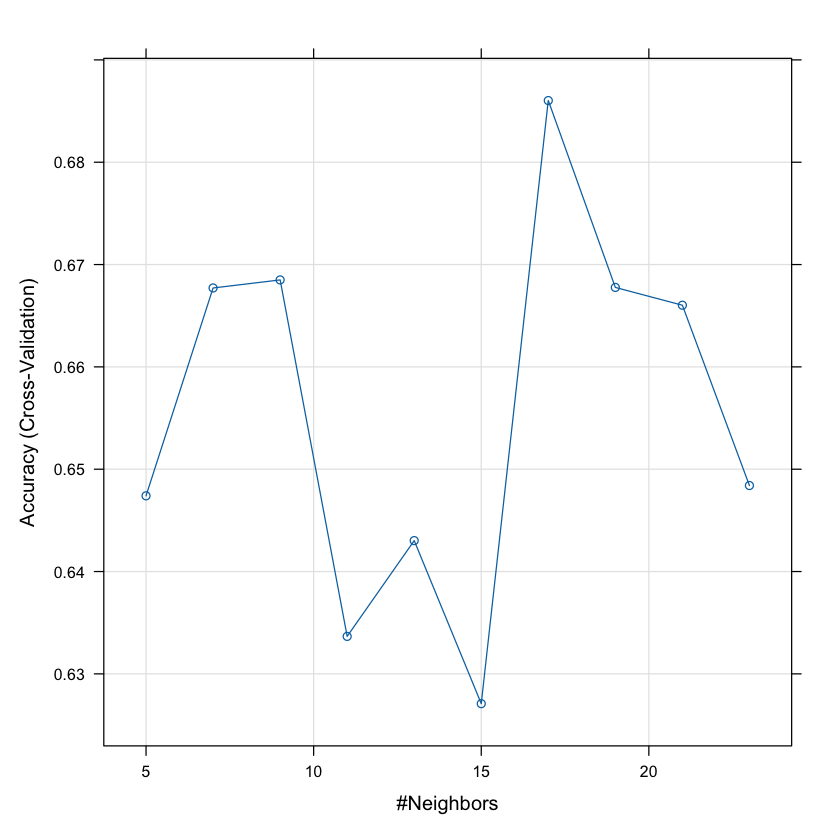

In [272]:
# Accuracy by number of neighbors (k)
plot(knnFit)

In [3]:
knn_train_pred <- predict(knnFit, newdata = covid_train)
accuracy(covid_train$risk_level, knn_train_pred)

ERROR: Error: object 'knnFit' not found


### 3.1.10 Model Comparison Summary

| Model              | Cross-Validated Accuracy | Test Accuracy | Notes |
|-------------------|--------------------------|---------------|-------|
| Baseline (Constant) | ~33.33%                 | ~33.33%       | Predicts majority class only |
| Decision Tree (rpart) | ~98.78%              | ~97.73%       | Best performance, interpretable |
| k-Nearest Neighbors (kNN) | Varies (~65–70%) | ~66–70%       | Performance depends on `k`; weaker than tree |

The decision tree clearly outperforms both the baseline and kNN models, achieving high accuracy and interpretability. The kNN classifier performs moderately well but shows lower precision for minority classes. The baseline model serves as a benchmark and demonstrates the value of using supervised learning for this classification task.

In [281]:
# Compute and print accuracies
cat("Baseline Accuracy: ", accuracy(covid_test$risk_level, baseline_pred), "\n")
cat("Decision Tree Accuracy: ", accuracy(covid_test$risk_level, rpart_pred), "\n")
cat("kNN Accuracy: ", accuracy(covid_test$risk_level, knn_pred), "\n")

Baseline Accuracy:  0.3333333 
Decision Tree Accuracy:  0.969697 
kNN Accuracy:  0.6060606 


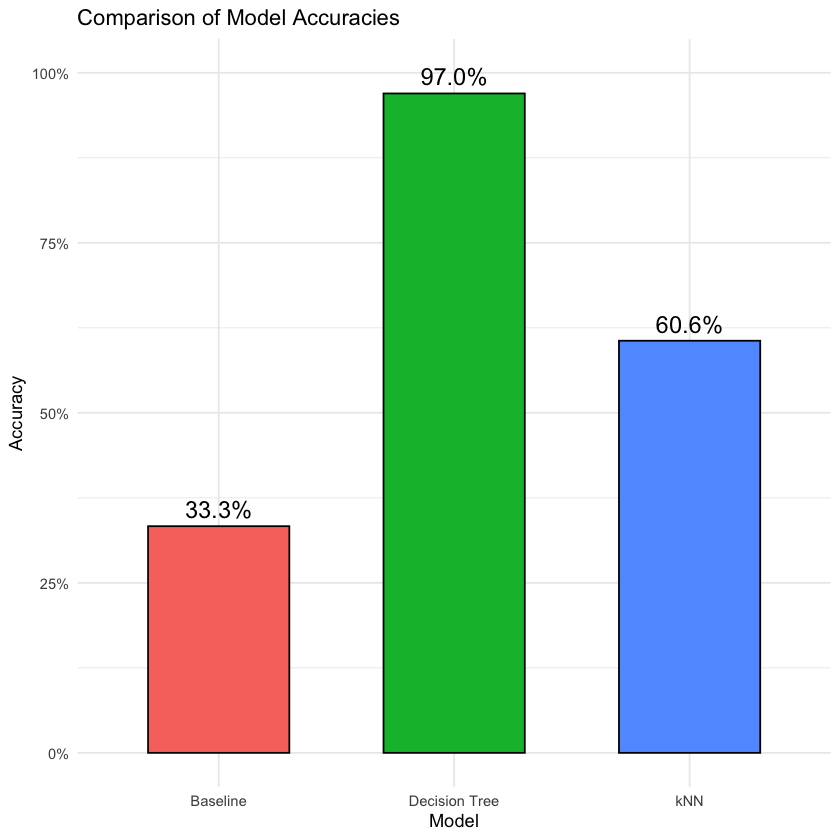

In [284]:
# Create a data frame with model names and accuracies
model_results <- data.frame(
  Model = c("Baseline", "Decision Tree", "kNN"),
  Accuracy = c(0.3333, 0.9696, 0.6060)  # Replace with your actual accuracy values
)

# Plot the bar chart
ggplot(model_results, aes(x = Model, y = Accuracy, fill = Model)) +
  geom_bar(stat = "identity", color = "black", width = 0.6) +
  geom_text(aes(label = scales::percent(Accuracy, accuracy = 0.1)), 
            vjust = -0.5, size = 5) +
  scale_y_continuous(labels = scales::percent_format(), limits = c(0, 1)) +
  labs(
    title = "Comparison of Model Accuracies",
    x = "Model",
    y = "Accuracy"
  ) +
  theme_minimal() +
  theme(legend.position = "none")

### 3. Evaluation [5 points]
Discuss how useful your model is for your chosen stakeholders. How would you assess the model's value if
it was used?

### 4. Deployment [5 points]
• How would your model be used in practice? What actions would be taken based on your model? How often would the model be updated? Etc.